# Import modules needed

In [1]:
import numpy as np
from scipy.integrate import simps
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field. The `integer` parameter let's the function decide whether we want an integer $\mathcal S$ (`integer='S'`) or an integer $\mathcal F$ (`integer ='F'`). Subsequently, the function has the optional parameters `S` and `F`, one of which must be defined depending on the choice of `integer`. The function also takes as parameters; the number of generations $\mathcal G$, the fractal dimension, $D$, and the Euclidean dimension, $E$.

If we want an integer $\mathcal S$ the function calculates, $\mathcal{F}$, $\mathcal{F}_{\rm{ST}}$, $\mathcal{F}_{\rm{LO}}$, $\mathcal{F}_{\rm{HI}}$, and $\Delta\mathcal{F}$. It then sets up the appropriate values of $\mathcal{F}$ and $\mathcal G$ with which to pass to `coord_func`. The first $\mathcal F$ value is equal to $\mathcal{F}_{\rm{ST}}$, the rest are set as follows:

\begin{eqnarray}
{\cal F}_{_{\rm{LO}}}\,,&{\rm{if}}&{\cal L}>\Delta{\cal F}\,,\\
{\cal F}_{_{\rm{HI}}}\,,&{\rm{if}}&{\cal L}<\Delta{\cal F}\,.
\end{eqnarray}

A set of points are generated $E$ times to get an $E$-dimensional set of coordinates.

`fractal_point_gen` also has the option to pass these coordinates to the `star_culling` function before returning them.

The function `star_culling` takes a set of coordinates and culls points randomly to a desired number.

The function `fractal_field_gen` returns a histogram based on `fractal_point_gen`.

In [2]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        L = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(L>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        S=F**(1/D)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g in G_array:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,F)]
            points.append(x)
    if N_points:
        points = star_culling(points,N_points)
    return points

def star_culling(points, N_points):
    while len(points[0])>N_points:
        n=1+int(np.random.random()*(len(points[0])-1))
        for i in range(0,len(points)):
            del points[i][n-1]
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

The functions below deal with calculating the cumulative probability distribution for the separations of a set of points.

Given a set of $\cal I$ stars, where each star has position $\mathbf r_i \equiv (x_i,y_i)$, the cumulative probability probability distribution is,

$$P(s) \simeq \frac{2\cal N(<s)}{\cal I (\cal I -1)}$$

where $\cal N(<s)$ is the number of separations less than $s$. 

This requires us to compute all inter-star separations,

$$s_{ij} = \big|\mathbf r_i - \mathbf r_j\big|$$

making sure we only count each separation once.

The function `ordered_separations` computes all the unique separations for a set of points.

The function `cum_dist_seps` takes a set of points, its separations, and the value $s$ and computes the cumulative probability that a separation is less than $s$.

The function `two_pt_corr` takes the set of points, the cumulative probability, $P(s)$, and the value $s$ and computes the two-point correlation function according to,

$$
\xi_2(s) \simeq \frac{dP/ds}{2\pi s \tilde N}-1
$$

for 2-dimensions, or,

$$
\xi_3(s) \simeq \frac{dP/ds}{4\pi s^2 \tilde N}-1
$$

where $\tilde N = \cal I/\cal A$ with $\cal A$ being the area/volume of the convex hull of the set of points.

In [3]:
from scipy.spatial import ConvexHull

def ordered_separations(points):
    coords = [point for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def cum_dist_seps(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

def two_pt_corr(coords, P_s, s):
    coords=np.array(coords).T
    E = len(coords[0])
    I = len(coords)
    V = ConvexHull(coords).volume
    N_bar = I/V
    dpds = np.gradient(P_s,s[1]-s[0])
    return (dpds/(2*(E-1)*np.pi*(s**(E-1))*N_bar)) - 1

# Implementation

In [4]:
N_fields = 10
S_LIST=[2,3]*N_fields
D = 2.3
G_LIST = [6,4]*N_fields
E=3

params = np.array([S_LIST,G_LIST]).T
params[:10]

array([[2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4]])

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [19:24<00:00, 61.75s/it]


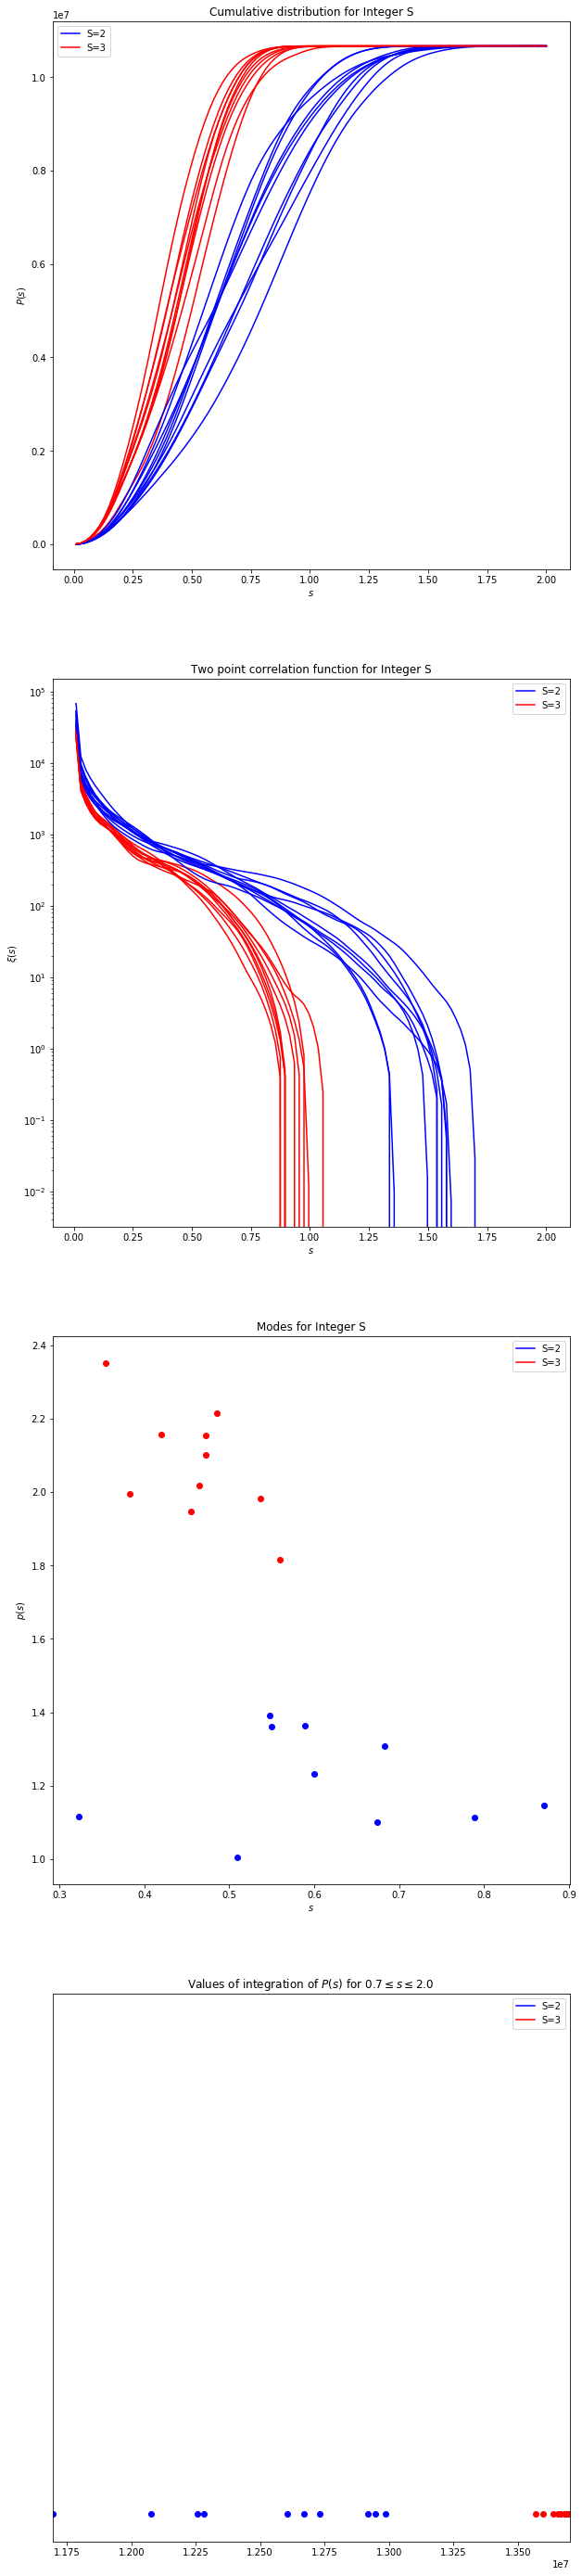

In [5]:
min_stars = 8000
s_factors = np.linspace(0.01,2,100)

f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (10,50))
ax1.plot([], label='S=2', color="blue")  
ax1.plot([], label="S=3", color="red")
ax2.plot([], label='S=2', color="blue")  
ax2.plot([], label="S=3", color="red") 
ax3.plot([], label='S=2', color="blue")  
ax3.plot([], label="S=3", color="red")  
ax4.plot([], label='S=2', color="blue")  
ax4.plot([], label="S=3", color="red")  

integration_values = []

for s,g in tqdm(params):
    field = fractal_point_gen('S',g,D,E,S=s)
    while len(field[0]) < min_stars:
        print('Number of stars generated:', len(field[0]))
        field = fractal_point_gen('S',g,D,E,S=s)
    culled_field = star_culling(field, min_stars)
    separations = ordered_separations(culled_field)
    P_s = np.array([cum_dist_seps(culled_field,separations,s) for s in s_factors])
    xi = two_pt_corr(field,P_s,s_factors)
    
    n, bins, patches = ax4.hist(separations, bins=100, normed=True, fc='k', alpha=0.3)
    bins_centred = np.array([(bins[i]+bins[i+1])/2 for i in range(100)])                      
    mode = bins_centred[np.argmax(n)]
    P_mode = np.max(n)
    
    s_factors_slice = s_factors[np.where(s_factors>0.7)]
    P_s_slice = P_s[np.where(s_factors>0.7)]
    
    integration_value = simps(P_s_slice, s_factors_slice)
    integration_values.append(integration_value)
    
    
    if s==2:
        ax1.plot(s_factors,P_s, c='b')
        ax2.plot(s_factors,xi, c='b')
        ax3.scatter(mode,P_mode, c='b')
        ax4.scatter(integration_value, 0, c='b')
    if s==3:
        ax1.plot(s_factors,P_s, c='r')
        ax2.plot(s_factors,xi, c='r')
        ax3.scatter(mode,P_mode, c='r')
        ax4.scatter(integration_value, 0, c='r')
    
ax1.set_title('Cumulative distribution for Integer S')
ax1.set_ylabel(r'$P(s)$')
ax1.set_xlabel(r'$s$')
ax1.legend()

ax2.set_title('Two point correlation function for Integer S')
ax2.set_ylabel(r'$\xi(s)$')
ax2.set_xlabel(r'$s$')
ax2.legend()
ax2.set_yscale('log')

ax3.set_title('Modes for Integer S')
ax3.set_ylabel(r'$p(s)$')
ax3.set_xlabel(r'$s$')
ax3.legend()

ax4.set_title(r'Values of integration of $P(s)$ for $0.7\leq s\leq 2.0$')
ax4.set_xlim(np.min(integration_values), np.max(integration_values))
ax4.set_yticks([])
ax4.legend()

plt.rcParams.update({'font.size': 20})
plt.show()

# To do list:

- SVM for mode, also try for skewness, kurtosis, mean, median etc.
- Build CNN on Density field, increase number of points by increasing G in order to fill in the 2d histogram.
- Investigate area under curve of cumulative distribution for s>0.7

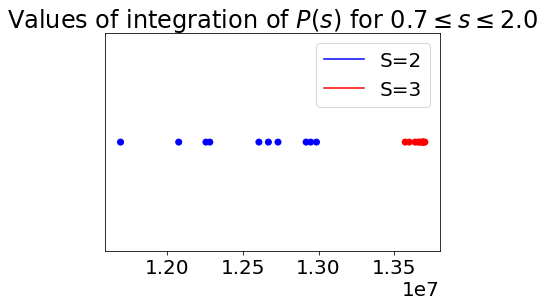

In [6]:
plt.figure()
plt.scatter(integration_values, np.zeros_like(integration_values), c = params.T[0], cmap = 'bwr')

plt.yticks([])
plt.plot([], label='S=2', color="blue")  
plt.plot([], label="S=3", color="red")
plt.title(r'Values of integration of $P(s)$ for $0.7\leq s\leq 2.0$')
plt.legend()
plt.show()